In [1]:
import numpy as np
import matplotlib.pyplot as plt
from neural_network.trainutils import *
import os

np.random.seed(0)

In [2]:
current_dir = os.getcwd()
face_dir = os.path.join(current_dir, "cmu+face+images", "faces")
iterations = 1000
k = 64
dataset = NMFDataset(face_dir)
dataset.nmf(k, iterations)

100%|██████████| 1000/1000 [03:26<00:00,  4.84it/s]


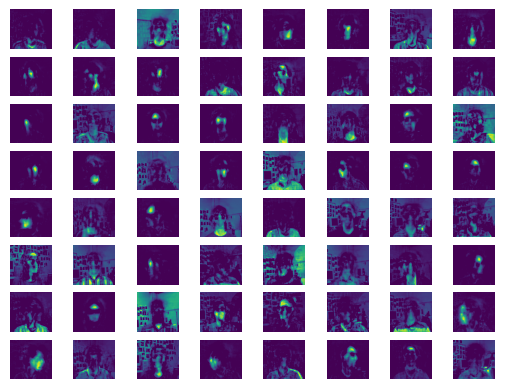

In [3]:
#Plot NMF-faces
plt.figure()
plot_dim = 8
for i in range(plot_dim):
    for j in range(plot_dim):
        plt.subplot(plot_dim, plot_dim, plot_dim*i + j + 1)
        plt.imshow(dataset.H[plot_dim*i + j,:].reshape((120, 128)))
        plt.axis("off")

In [4]:
#save
import pickle

with open('nmfdataset.pickle', 'wb') as handle:
    pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [1]:
#load
import pickle

with open('nmfdataset.pickle', 'rb') as handle:
    dataset = pickle.load(handle)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from neural_network.trainutils import *
import os

np.random.seed(0)

In [3]:
train_dataset, _, test_dataset = train_test_split(dataset, dataset_type="nmf")

In [4]:
len(train_dataset), len(test_dataset)

(499, 125)

In [1]:
import pickle

In [10]:
with open('nmfdataset_train.pickle', 'wb') as handle:
    pickle.dump(train_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('nmfdataset_test.pickle', 'wb') as handle:
    pickle.dump(test_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from neural_network.trainutils import *
import os

np.random.seed(0)

In [2]:
import pickle

with open('nmfdataset_train.pickle', 'rb') as handle:
    train_dataset = pickle.load(handle)
with open('nmfdataset_test.pickle', 'rb') as handle:
    test_dataset = pickle.load(handle)

In [3]:
train_dataset

In [7]:
train_dataset.data[0, np.arange(64)].shape

(64, 1)

In [7]:
len(train_dataset)

499

In [4]:
train_dataset.data[0].shape

(64, 1)

In [5]:
train_dataset[0][0].shape

(64, 1)

In [4]:
remaining_features = backward_feature_selection(train_dataset)

16
current min: [1.40263858], new loss: [1.40263858]
current min: [1.40263858], new loss: [1.43237574]
current min: [1.39947874], new loss: [1.39947874]
current min: [1.39947874], new loss: [1.43864186]
current min: [1.39947874], new loss: [1.41991488]
current min: [1.39947874], new loss: [1.42826878]
current min: [1.37750453], new loss: [1.37750453]
current min: [1.37750453], new loss: [1.43888748]
current min: [1.37750453], new loss: [1.39920085]
current min: [1.37750453], new loss: [1.43083959]
current min: [1.37222488], new loss: [1.37222488]
current min: [1.37222488], new loss: [1.39435169]
current min: [1.37222488], new loss: [1.41885646]
current min: [1.37222488], new loss: [1.40240879]
current min: [1.37222488], new loss: [1.45024643]
current min: [1.37222488], new loss: [1.41039557]
64 min: [1.37222488] prev [1.35634521] [23 15 47 11]


In [5]:
remaining_features

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])